CocaCola sales seem to follow a cycle of four quarters (using quarterly data). We model the sales below.

In the linear model of seasonality:

![image.png](attachment:image.png)

the coefficients of the dummy variables b1, b2 and b3 indicate how much each quarter differs from the reference quarter, quarter4.
The average increase from one quarter to the next is b (the coefficient of t). This is the trend effect.  Quarter 1 averages b1 units higher than the reference quarter, quarter 4, quarter 2 averages b2 units higher than quarter 4, etc. These other coefficients indicate the effect of seasonality. 


In what follows we are implementing a multiplicative seasonal model of seasonality:


![image.png](attachment:image.png)

Which after taking logs is:

![image.png](attachment:image.png)

In this multiplicative model the coefficients are percentage changes in the original sales variable Y.  The coefficient of time means that deseasonalized sales increase by b% per quarter. This is the trend effect. The coefficients b1, b2 and b3 mean that the sales in quarters 1, 2 and 3 are respectively b1% above quarter 4, b2% above quarter 4 and b3% above quarter 4. Quarter 4 is the reference quarter.

In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
#The following function is borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries pandas series
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Agumented Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [141]:
def detrendPrice(dft):
    #make sure the input dft has no Nan, otherwise OLS will break
    # fit linear model
    series=dft.Sales
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    results = model.fit()
    predictions = results.predict(x_const)
    resid = y - predictions
    df=pd.DataFrame(resid, columns=['Sales'])
    df.index = dft.index
    return df

In [142]:
def MAD_mean_ratio(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

In [143]:
#The following 2 functions are borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

def plotModelResults(model, X_train, X_test, y_test, plot_intervals=False, test_data=True):
    """
        Plots modelled vs fact values, prediction intervals
    
    """
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    error = MAD_mean_ratio(prediction, y_test)
    if (test_data==True):
        plt.title("Test data MAD_mean_ratio error {0:.2f}%".format(error))
    else:
        plt.title("Train data MAD_mean_ratio error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model,X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [144]:
#my code starts here
df=pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)
df['datetime'] = pd.to_datetime(df['Date'])

df = df.set_index('datetime')
df.dropna(inplace=True)

df.drop(['Date'], axis=1, inplace=True)
df.head(5)

,Sales
datetime,
1986-04-01,1734.83
1986-07-01,2244.96
1986-10-01,2533.80
1987-01-01,2154.96
1987-04-01,1547.82


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


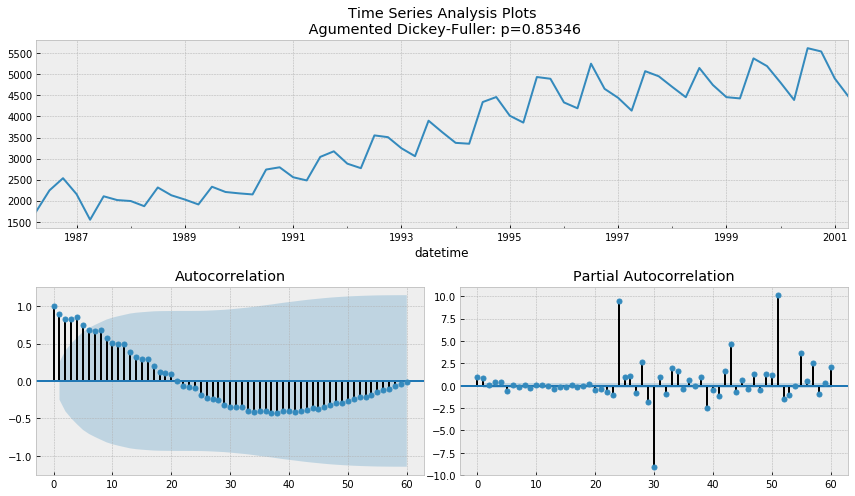

In [145]:
tsplot(df.Sales, lags=60)

In [146]:
# CAN YOU GUYS CHECK THIS QUESTION BELOW? NOT SURE THE ANSWER
# the assignment says try to determine the number of quarters in a seasonal cycle in the autocorrelation plot
#Answer: 4 quaters per seasonal cycle 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


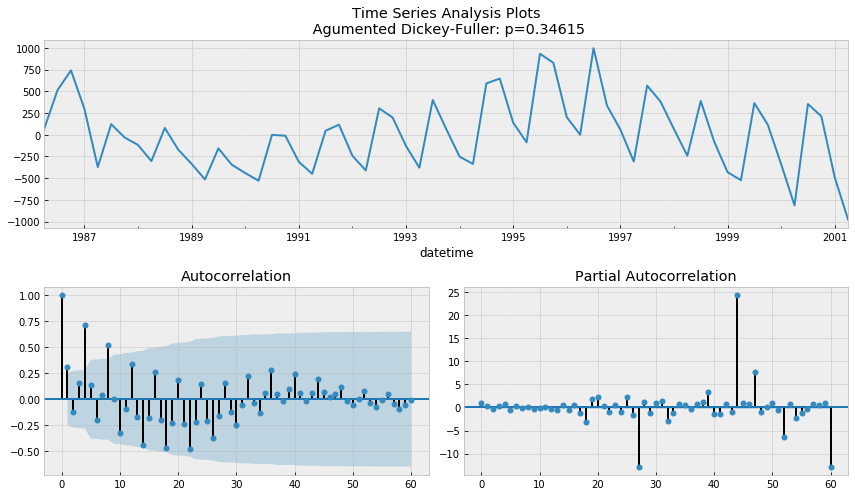

In [147]:
df_detrended = detrendPrice(df)
tsplot(df_detrended.Sales, lags=60)
# CAN YOU GUYS CHECK THE ANSWER FOR THIS QUESTIONS BELOW TOO?
#try to determine the number of quarters in a seasonal cycle in the autocorrelation plot
#Answer: 4 quaters per seasonal cycle

In [148]:
df["Sales"] = np.log(df.Sales)
df["quarter"]=df.index.quarter
df.head()

,Sales,quarter
datetime,,
1986-04-01,7.458665,2
1986-07-01,7.716443,3
1986-10-01,7.837475,4
1987-01-01,7.675527,1
1987-04-01,7.344603,2


In [149]:
df_dummies = pd.get_dummies(df["quarter"], prefix='quarter')
df_dummies.head()

,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,
1986-04-01,0,1,0,0
1986-07-01,0,0,1,0
1986-10-01,0,0,0,1
1987-01-01,1,0,0,0
1987-04-01,0,1,0,0


In [150]:
#using df.join(df_dummies), join the dummy variables to the original data
#and save the result back in df
#print the df.head(), it should look like:


df=df.join(df_dummies)
df.head()

,Sales,quarter,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,,,
1986-04-01,7.458665,2,0,1,0,0
1986-07-01,7.716443,3,0,0,1,0
1986-10-01,7.837475,4,0,0,0,1
1987-01-01,7.675527,1,1,0,0,0
1987-04-01,7.344603,2,0,1,0,0


In [151]:
#using df.drop(["quarter","quarter_4"], inplace=True, axis=1) drop these two columns
#print the df.head(), it should look like:

df.drop(["quarter","quarter_4"], axis=1, inplace=True)
df.head()

,Sales,quarter_1,quarter_2,quarter_3
datetime,,,,
1986-04-01,7.458665,0,1,0
1986-07-01,7.716443,0,0,1
1986-10-01,7.837475,0,0,0
1987-01-01,7.675527,1,0,0
1987-04-01,7.344603,0,1,0


In [152]:
# declare an empty list = []
# using the list(range(0, dft.shape[0])) function and the fact that df.shape[0] contains the number of rows in the df
# generate a list going from 0,1,2,....,60 (the number of rows in the df)
# and save the result in df["time"] = list
# print the df.head(), it should look like:

list_empty=[]
list_empty=list(range(0, df.shape[0]))
#print(list_empty)
df["time"]=list_empty
df.head()

,Sales,quarter_1,quarter_2,quarter_3,time
datetime,,,,,
1986-04-01,7.458665,0,1,0,0
1986-07-01,7.716443,0,0,1,1
1986-10-01,7.837475,0,0,0,2
1987-01-01,7.675527,1,0,0,3
1987-04-01,7.344603,0,1,0,4


In [153]:
# Save the df.["Sales"] column into the variable y
# use df.drop(["Sales"], inplace=True, axis=1) to drop the Sales column
# Save the df into the X variable
y = df.dropna().Sales
X = df.dropna().drop(['Sales'], axis=1)


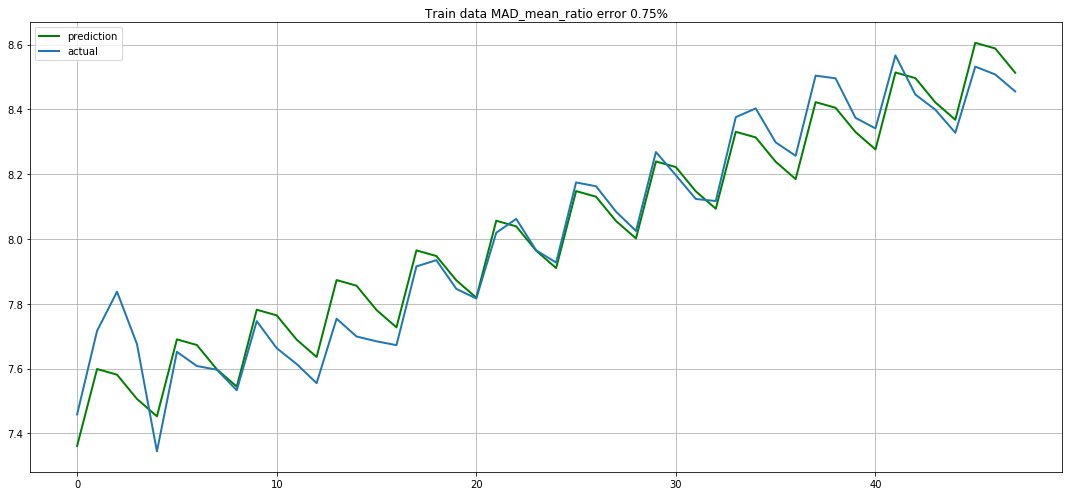

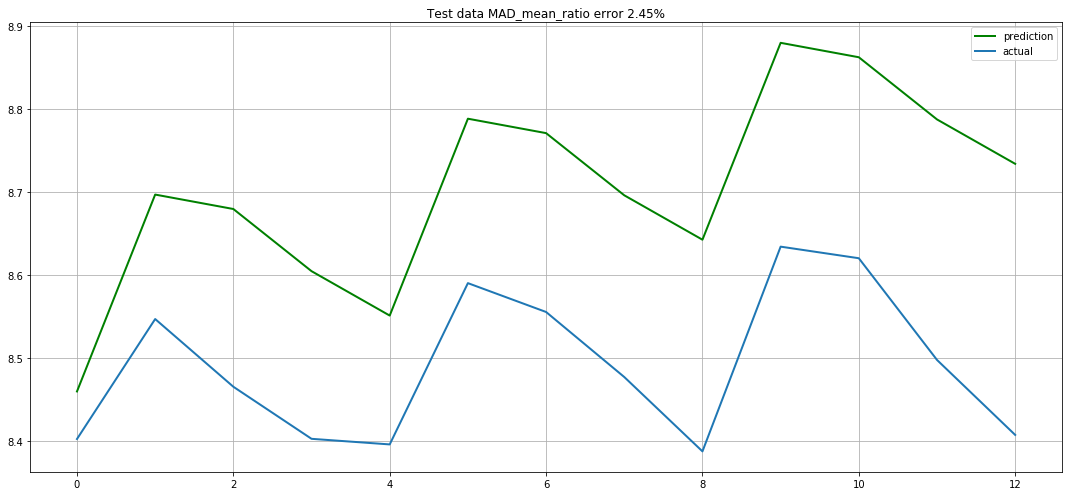

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2, shuffle=False)
lr = LinearRegression()
lr_fitted = lr.fit(X_train, y_train)
predictions_train = lr_fitted.predict(X_train)
predictions_test = lr_fitted.predict(X_test)

# plt.scatter(X_train, y_train, color = "red")
# plt.plot(X_train, lr.predict(X_train), color = "green")
# plt.title("predictions vs true values")
# plt.xlabel("X")
# plt.ylabel("y")
# plt.show()

#CAN YOU GUYS CHECK IF THIS FUNCTION IS USED CORRECTLY? NOT SURE WHY X_TEST IS SET AS X_TRAIN AND Y_TEST=Y_TRAIN
plotModelResults(lr_fitted, X_train=X_train, X_test=X_train, y_test=y_train, plot_intervals=False, test_data=False)
plotModelResults(lr_fitted, X_train=X_train, X_test=X_test, y_test=y_test, plot_intervals=False, test_data=True)

In [155]:
# print(X_train)
# print(y_train)

In [156]:
train_error = MAD_mean_ratio(y_train,predictions_train)
test_error = MAD_mean_ratio(y_test,predictions_test)

print("The train MAD Mean Ratio is",train_error )
print("The test MAD Mean Ratio is", test_error)


The train MAD Mean Ratio is 0.7513756334676818
The test MAD Mean Ratio is 2.5127729607789804


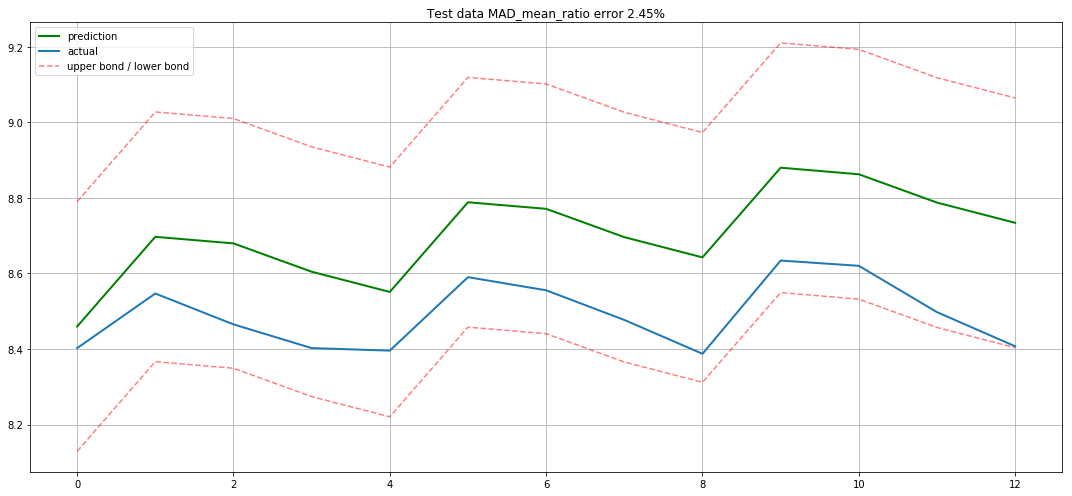

In [157]:
plotModelResults(lr_fitted, X_train=X_train, X_test=X_test, y_test=y_test, plot_intervals=True, test_data=True)


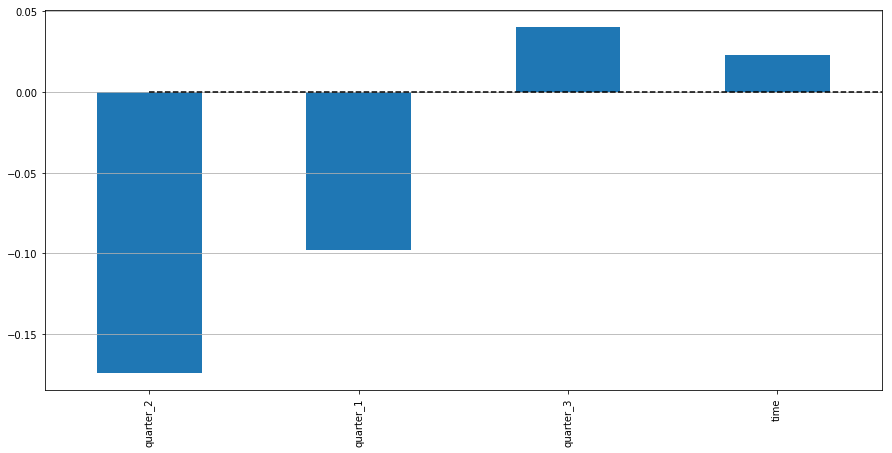

In [158]:
plotCoefficients(lr_fitted,X_train)

Now let us try to bring down the error in the test predictions by introducing error (bias) into the train predictions, that is, by making the regression fit the train data not so well as before, so that it can predict the test data better. We do this by using a Ridge regression and looking for the regularization value of the alpha parameter. These are the steps:

In [159]:
#Load and visualize the unscaled data
y = df.dropna().Sales
X = df.dropna().drop(['Sales'], axis=1)

#Divide the data into test and train set: 80% train 20% test: train_test_split(X, y, test_size=.2, shuffle=False, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2, shuffle=False)


In [160]:
#Set up a pipeline to scale the data appropriately during grid search: Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])




In [161]:
#Separate out a percent of the train set as validation data: 20% (5 folds cv=5): TimeSeriesSplit(n_splits=5)
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)


#Use the validation data to select the model with best parameters: GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_absolute_error")
from sklearn.model_selection import GridSearchCV
param_grid = [{'ridge__alpha':[1000,500,100,50,10,5,1,.5,.1]}]
grid_search = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_absolute_error")              
grid_search.fit(X_train,y_train)
best_parameters=grid_search.best_params_


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all conv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float

In [162]:
#Instatiate and train (=fit) a new model with the best parameters on the training data
#Test (=predict) the model on the testing data

chosen_model = Ridge(alpha=best_parameters['ridge__alpha'])
scale_fit=StandardScaler()
X_train_scaled = scale_fit.fit_transform(X_train)
X_test_scaled = scale_fit.transform(X_test)
chosen_model.fit(X_train_scaled, y_train)

predictions_train = chosen_model.predict(X_train_scaled)
predictions_test = chosen_model.predict(X_test_scaled)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  import sys


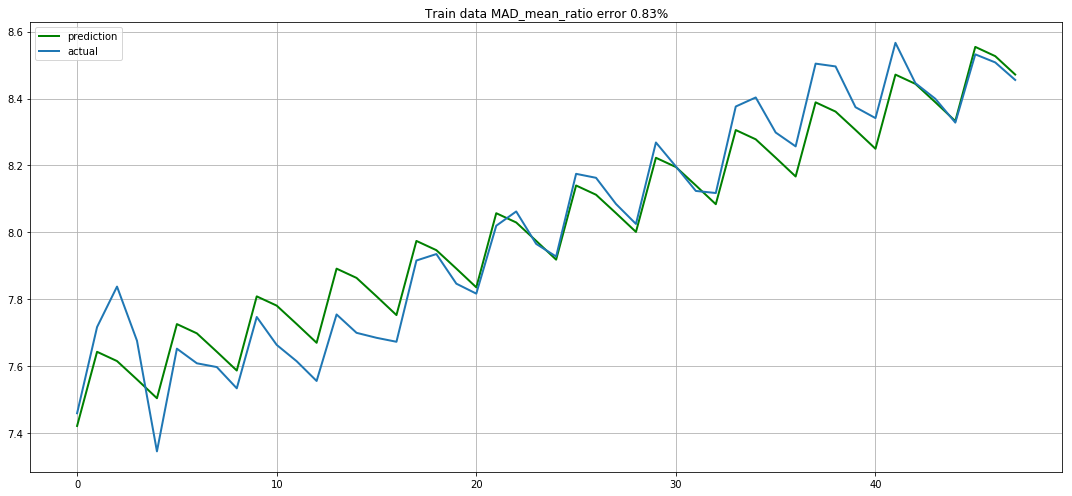

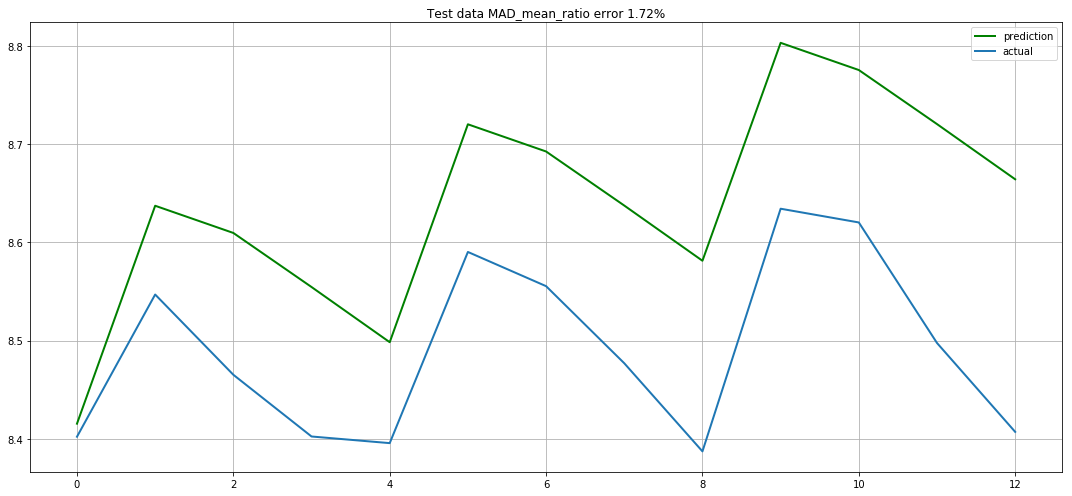

In [163]:
#Plot the predictions vs true values
#CAN YOU GUYS CHECK IF THIS FUNCTION IS USED CORRECTLY? NOT SURE WHY X_TEST IS SET AS X_TRAIN AND Y_TEST=Y_TRAIN
plotModelResults(chosen_model, X_train=X_train_scaled, X_test=X_train_scaled, y_test=y_train, plot_intervals=False, test_data=False)
plotModelResults(chosen_model, X_train=X_train_scaled, X_test=X_test_scaled, y_test=y_test, plot_intervals=False, test_data=True)


In [164]:
#Evaluate the model using a metric (=MAD/MEAN RATIO score)

train_error = MAD_mean_ratio(y_train,predictions_train)
test_error = MAD_mean_ratio(y_test,predictions_test)

print("The train MAD Mean Ratio is",train_error )
print("The test MAD Mean Ratio is", test_error)

The train MAD Mean Ratio is 0.8263676061019088
The test MAD Mean Ratio is 1.746693592777291


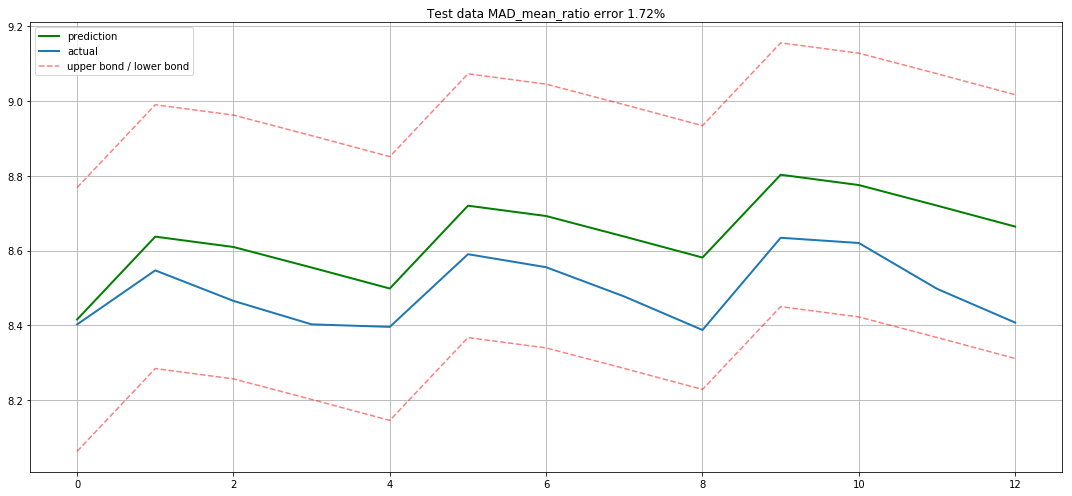

In [165]:
plotModelResults(chosen_model, X_train=X_train_scaled, X_test=X_test_scaled, y_test=y_test, plot_intervals=True, test_data=True)


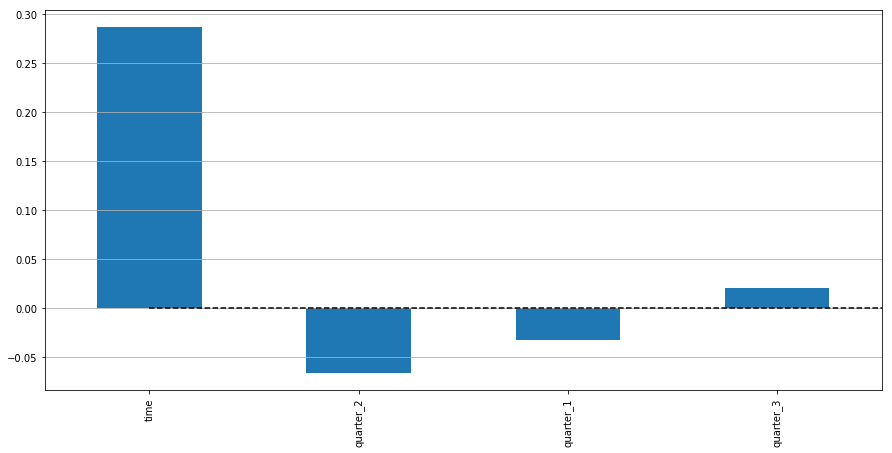

In [166]:
plotCoefficients(chosen_model,X_train)

This marks the end of the assignment 